Homework 2

In this assignment, we will expand our 1-D Ising model to 2-D, implementing the
Metropolis-Hastings algorithm. We will perform "sweeps" through the 2-D lattice 
of size $\Lambda = N_x \times N_y$.

Questions:

2. How does numerical cost of the calculation of the 
energy scale with system size $\Lambda$?
3. Assuming you’ve flipped one spin $s_i$, how does the numerical cost of the calculation of the change in energy ∆S scale with the system size Λ?
4. Significance of critical coupling $J_c$

2. Calculation of the energy scales with system size $\Lambda$ as $O(\Lambda)$, as a pass to calculate this involves traversing through all the lattice points for a finite number of times. So, time to determine energy is ~ $O(\Lambda)$.

3. We have the expression for change of energy $Δ S$ derived analytically, \\
$\Delta S = 2J s_x (s_{x-1} + s_{x+1}) + 2s_xh$. 
So to determine the value of $Δ S$ we don't need to run an entire cycle of traversing through the lattice points. So, the order of time to determine $Δ S$ is $O(1)$.

4. $J_c$ represents the coupling at the critical temperature, $T_c$. The critical temperature is the point at which phase transition occurs. 

In [5]:
import numpy as np

In [6]:
def H(s, J, h):
  '''Hamiltonian for a particular spin configuration in 2D'''

  # get coupling term
  coupling_term = eval_coupling(s)

  # get external magnetic field term
  bfield_term = np.sum(s)

  return -J * coupling_term - h * bfield_term

def eval_coupling(s):
  '''evaluate coupling term with nearest neighbours'''
  Nx, Ny = s.shape
  coupling_term = 0.
  return np.sum([
      s[x,y]*(s[(x+1)%Nx,y]+s[(x-1)%Nx,y]+s[x,(y-1)%Ny]+s[x,(y+1)%Ny]) 
      for x in range(Nx) for y in range(Ny) 
  ])

def P_factor(s, J, h, T):
  '''Boltmann distribution factor'''
  return np.exp(-H(s, J, h) / T)

def partition(s_arr, J, h, T):
  '''Partition function'''
  return np.sum([P_factor(s, J, h, T) for s in s_arr])

def deltaS(flip_idx, s, J, h, T, Nx, Ny):
  '''Change in action with flip of spin at flip_idx'''
  x, y = flip_idx
  coupling_term = J*(s[(x+1)%Nx,y] + s[(x-1)%Nx,y] \
                      + s[x,(y+1)%Ny] + s[x,(y-1)%Ny])
  return 2 * s[x,y]*(coupling_term + h)

# Observables below
def m(s):
  '''Magnetization per spin as function of spin configuration'''
  return np.mean(s)

def en(s, J, h):
  '''Energy per spin'''
  Nx, Ny = s.shape
  return H(s, J, h) / (Nx*Ny)

def m_abs(s):
  '''Absolute value of magnetization per spin'''
  return np.abs(np.mean(s))

In [10]:
def init_spin(Nx, Ny, J, h, T, Ntherm=100):
  '''Initialize spins based on Metropolis-Hastings algorithm'''

  # set initial spins to be equally up and down
  s0 = np.ones((Nx, Ny))
  for i in range(Nx):
    for j in range(Ny):
      if (i+j)%2 == 1:   # every index where sum of indices is odd number
        s0[i, j] *= -1

  # thermalize (get a random initial configuration)
  for k in range(Ntherm):
    for l in range(Nx*Ny):
      i, j = np.random.randint(0, Nx), np.random.randint(0, Ny) 

      # evaluate change in action
      dS = deltaS((i,j), s0, J, h, T, Nx, Ny)
      y = np.random.uniform(0, 1)
      if y <= np.exp(-dS):  
        s0[i,j] *= -1
      else:
        pass  # return original

  return s0

def run(s, Nx, Ny, J, h, T, Nmeasure, obsv="m"):
  '''
  Run the algorithm and obtain the observables
  obsv = "m" (magnetization), "en"(energy), "m_abs"(|m|)
  '''

  # # set up lattice
  # iterate over each measurement
  obsv_arr = np.zeros(Nmeasure)
  # prob_arr = np.zeros(Nx*Ny)
  
  for k in range(Nmeasure):
    for l in range(Nx*Ny):
      i, j = np.random.randint(0, Nx), np.random.randint(0, Ny) 

      # evaluate dS at flipped location
      dS = deltaS((i,j), s, J, h, T, Nx, Ny)

      # perform metropolis-hastings step
      y = np.random.uniform(0, 1)
      if y <= np.exp(-dS):  
        s[i,j] *= -1
        # prob_arr[i*Nx + j] = 1
      else:
        pass  # return original

    # evaluate observable here for each measurement
    if obsv == "m":
      obsv_arr[k] = m(s)
    elif obsv == "en":
      obsv_arr[k] = en(s, J, h)
    elif obsv == "m_abs":
      obsv_arr[k] = m_abs(s)
    else:
      raise ValueError("No observable named {0} found.".format(obsv))
  
  # return <o> per measurement and accept / reject for this measurement
  return np.mean(obsv_arr)  

  

In [45]:
# set initial parameters
J = 0.5
T = 1  # set low since we perform with lattice spins
Nx = 5
Ny = 5   

# observable
obsv = "m"

Lmbda = Nx * Ny # total number of lattice sites
Nmeasure = 1000   # number of measurements to perform
h_arr = np.linspace(-1, 1, 75)
m_exp_arr = np.zeros(len(h_arr))

# N_boot = 10  # number of bootstrap samples
# m_bootstrap = np.zeros((len(h_arr), N_boot))

for i, h in enumerate(h_arr):
  # array of spin configurations (N_config, Nl)
  s0 = init_spin(Nx, Ny, J, h, T)
  # print(s_arr)
  
  m_exp = run(s0, Nx, Ny, J, h, T, Nmeasure, obsv=obsv)

  m_exp_arr[i] = m_exp

  # for j in range(N_boot):
  #   m_boot = run(s0, Nx, Ny, J, h, T, Nmeasure, obsv=obsv)

  #   m_bootstrap[i, j] = m_boot

In [46]:
def bootstrap(og_arr):
  '''Bootsrapping to get the bootstrap mean and error'''
  N_param, N_og = og_arr.shape

  # number of bootstrap samples
  R = 100

  # error estimate for each observable per parameter
  std_arr = [] 

  # evaluate error over each parameter
  for k in range(N_param):
    boot_p = []   # bootstrap per parameter

    # get R bootstrap samples
    for j in range(R):
      r = np.random.randint(0,high=N_og,size=N_og)  # get random index
      temp = np.ones(N_og)

      # assign randomized magnetization
      for i in range(N_og):
        temp[i] = og[r[i]] 

      boot_p.append(temp)

    boot_p = np.array(boot_p)
    # bootstrap means
    mean_b = np.mean(boot_p, axis=1)
    # mean of bootstrap means
    mean_bs = np.mean(mean_b)

    # standard deviation of the bootstrap means
    # this is the error estimate of the observable
    std = np.sqrt( np.sum((mean_b -  mean_bs)**2) * 1/(R-1))

    std_arr.append(std)

  return std_arr

In [52]:
# Bootsrapping to get the bootstrap mean and error

# as an example, we bootstrap for a single magnetization element
# and assume we have len(h_arr) bootstrap samples.
m_og = m_exp_arr[-2]*np.ones_like(m_exp_arr)
N_og = m_og.size

R = 100  # number of bootstrap samples
m_boot = []

for j in range(R):
  r = np.random.randint(0,high=N_og,size=N_og)  # each random index
  m_temp = np.ones(N_og)

  # assign randomized magnetization
  for i in range(N_og):
    m_temp[i] = m_og[r[i]]   
  m_boot.append(m_temp)

m_boot = np.array(m_boot)

# bootstrap means
mean_b = np.mean(m_boot, axis=1)

# mean of bootstrap means
mean_bs = np.mean(mean_b)

# standard deviation of the bootstrap means
# this is the error estimate of the magnetization
std = np.sqrt( np.sum((mean_b -  mean_bs)**2) * 1/(R-1))

print("Error estimate for magnetization: {0:.5e}".format(std))

Error estimate for magnetization: 1.11582e-16


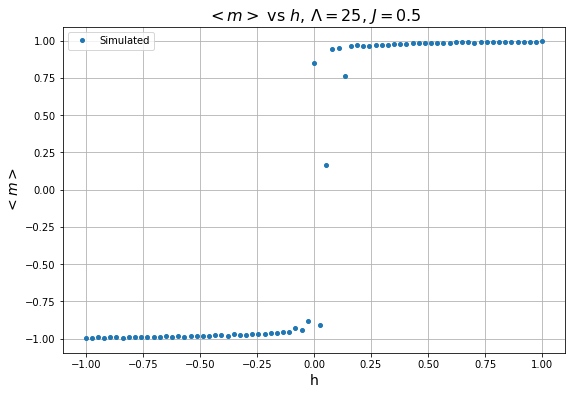

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9,6))

ax.plot(h_arr, m_exp_arr, ls="", marker="o", ms=4.0,label='Simulated')
ax.legend()
ax.set_xlabel('h', fontsize=14)
ax.set_ylabel('$<m>$', fontsize=14)
ax.set_title("$<m>$ vs $h$, $\Lambda = {0}$, $J = {1}$".format(Lmbda, J), fontsize=16)
ax.grid();

In [54]:
# set initial parameters
h = 0
T = 1  # set low since we perform with lattice spins
Nx = 5
Ny = 5    

# observable
obsv = "en"

Lmbda = Nx * Ny # total number of lattice sites
Nmeasure = 5000   # number of measurements to perform
J_arr = np.linspace(0.25, 2, 50)
en_exp_arr = np.zeros(len(J_arr))

for i, J in enumerate(J_arr):
  # array of spin configurations (N_config, Nl)
  s0 = init_spin(Nx, Ny, J, h, T)
  
  en_exp = run(s0, Nx, Ny, J, h, T, Nmeasure, obsv=obsv)

  en_exp_arr[i] = en_exp

In [55]:
from scipy.special import ellipk  # complete elliptical integral of the first kind

def en_exact(J):
  '''Analytical <en> with h=0 in thermo. limit in 2-D Ising model'''
  th = np.tanh(2 * J)  # tanh
  ch = np.cosh(2 * J)  # cosh

  K = ellipk(4 * (th / ch)**2.)
  K_prefactor = (2.  / np.pi) * (2. * th**2. - 1.)

  return - (J / th) * (1. + K_prefactor * K)

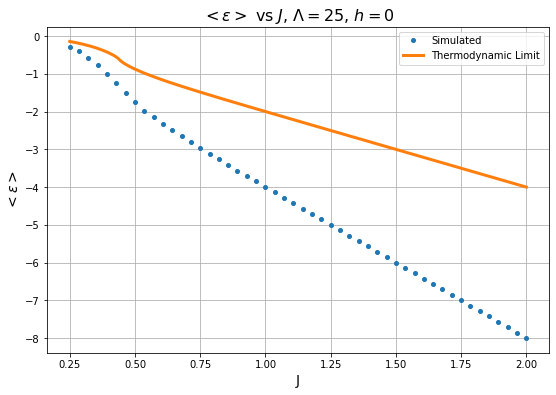

In [56]:
fig, ax = plt.subplots(figsize=(9,6))

J_exact = np.linspace(np.min(J_arr), np.max(J_arr), 200)

ax.plot(J_arr, en_exp_arr, ls="", marker="o", ms=4.0,label='Simulated')
ax.plot(J_exact, en_exact(J_exact),label='Thermodynamic Limit', lw=3.0)
# ax.plot(h_arr,mExact(J,h_arr),label='Thermodynamic Limit',ls=':', lw=3.0)
ax.legend()
ax.set_xlabel('J', fontsize=14)
ax.set_ylabel('$<\epsilon>$', fontsize=14)
ax.set_title("$<\epsilon>$ vs $J$, $\Lambda = {0}$, $h=0$".format(Lmbda),
             fontsize=16)
ax.grid();

In [57]:
# set initial parameters
h = 0
T = 1  # set low since we perform with lattice spins
Nx = 5
Ny = 5    

# observable
obsv = "m_abs"

Lmbda = Nx * Ny # total number of lattice sites
Nmeasure = 5000   # number of measurements to perform
J_arr = np.linspace(0.25, 1, 50)
mabs_exp_arr = np.zeros(len(J_arr))

for i, J in enumerate(J_arr):
  # array of spin configurations (N_config, Nl)
  s0 = init_spin(Nx, Ny, J, h, T)
  
  mabs_exp = run(s0, Nx, Ny, J, h, T, Nmeasure, obsv=obsv)

  mabs_exp_arr[i] = mabs_exp

In [58]:
def mabs_exact(J_arr):
  '''Analytical <|m|> with h=0 in thermodynamic limit for 2-D Ising model'''
  Jc = 0.5 * np.log(1 + np.sqrt(2))  # critical coupling constant
  mabs_arr = np.zeros_like(J_arr)
  for i, J in enumerate(J_arr):
    if J > Jc:
      mabs_arr[i] = (1. - 1. / (np.sinh(2 * J))**4. ) ** (1. / 8.)
    else:
      mabs_arr[i] = 0.
  
  return mabs_arr



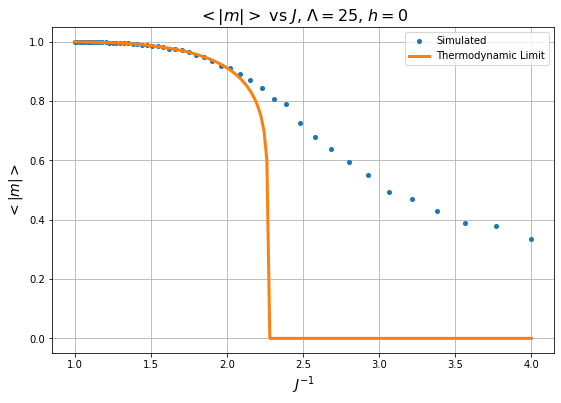

In [59]:
fig, ax = plt.subplots(figsize=(9,6))

J_exact = np.linspace(np.min(J_arr), np.max(J_arr), 200)

ax.plot(1. / J_arr, mabs_exp_arr, ls="", marker="o", ms=4.0,label='Simulated')
ax.plot(1. / J_exact, mabs_exact(J_exact),label='Thermodynamic Limit', lw=3.0)
ax.legend()
ax.set_xlabel('$J^{{-1}}$', fontsize=14)
ax.set_ylabel('$<|m|>$', fontsize=14)
ax.set_title("$<|m|>$ vs $J$, $\Lambda = {0}$, $h=0$".format(Lmbda),
             fontsize=16)
ax.grid();

7. The above plot is a plot between the mean of the absolute values of the magnetization and the inverse of the interaction term $J$. We see that when the value of $J^{-1}$ increases, or $J$ decreases, the value of of $<|m|>$ decreases. So that means that with a decrease in interaction between particles, the magnetization would also reduce. We can see this even in the Thermodynamic limit, where the mean of the absolute magnetization reduces with decreasing $J$.

In [60]:
# set initial parameters
h = 0
T = 1  # set low since we perform with lattice spins
Nx = 5
Ny = 5    

# observable
obsv = "m"

Lmbda = Nx * Ny # total number of lattice sites
Nmeasure = 5000   # number of measurements to perform
J_arr = np.linspace(0.25, 1, 50)
m_exp_arr = np.zeros(len(J_arr))

for i, J in enumerate(J_arr):
  # array of spin configurations (N_config, Nl)
  s0 = init_spin(Nx, Ny, J, h, T)
  
  m_exp = run(s0, Nx, Ny, J, h, T, Nmeasure, obsv=obsv)

  m_exp_arr[i] = m_exp

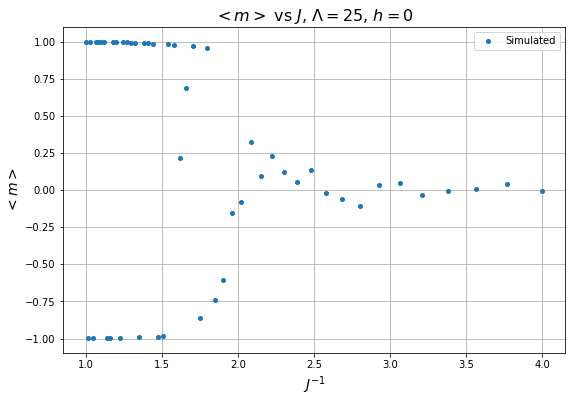

In [61]:
fig, ax = plt.subplots(figsize=(9,6))

J_exact = np.linspace(np.min(J_arr), np.max(J_arr), 200)

ax.plot(1. / J_arr, m_exp_arr, ls="", marker="o", ms=4.0,label='Simulated')
# ax.plot(1. / J_exact, m_exact(J_exact),label='Thermodynamic Limit', lw=3.0)
ax.legend()
ax.set_xlabel('$J^{{-1}}$', fontsize=14)
ax.set_ylabel('$<m>$', fontsize=14)
ax.set_title("$<m>$ vs $J$, $\Lambda = {0}$, $h=0$".format(Lmbda),
             fontsize=16)
ax.grid();

7. Plotting $<m>$ instead of $<|m|>$ shows us the that the plot is almost symmetric around the x-axis. At lower values of $J^{-1}$, the value of $<m>$ is near 1 or -1. And later on, it falls off to lower values. This is just like the case of $<|m|>$, but its only on one side of the x-axis.